In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [2]:
# Importing the dataset
df_transformed = pd.read_csv('../Datasets/preprocessed_data.csv')

In [4]:
df_transformed.head()

,PriorDefault,CreditScore,YearsEmployed,Income,Debt,Age,Employed,Approved
0,1,0.164272,0.239609,0.000000,0.000000,0.450783,1,1
1,1,0.461170,0.412554,0.549792,0.504099,0.819080,1,1
2,1,0.000000,0.270740,0.583290,0.120413,0.320834,0,1
3,1,0.424637,0.460392,0.120412,0.276829,0.392767,1,1
4,1,0.000000,0.294573,0.000000,0.561534,0.211771,0,1


In [3]:
# Splitting the dataset into training and testing sets with stratification
X = df_transformed.drop('Approved', axis=1)
y = df_transformed['Approved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Confirming the split
(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)


(((552, 7), (138, 7)), ((552,), (138,)))

In [6]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 150, 200],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Initialize Grid Search with the SVM model and the defined parameter grid
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')

# Fitting Grid Search to the training data
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

best_parameters, best_score

({'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}, 0.8622440622440622)

# Linear

In [4]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for LinearSVC
param_grid = {
    'C': [0.1, 1, 10, 100] 
}

# Initialize the LinearSVC
linear_svc = LinearSVC()

# Initialize the GridSearchCV object
grid_search_linear = GridSearchCV(linear_svc, param_grid, cv=5, scoring='accuracy')

# Fit it to the data
grid_search_linear.fit(X_train, y_train)

# Best parameters and best score
print(grid_search_linear.best_params_)
print(grid_search_linear.best_score_)

{'C': 0.1}
0.836953316953317


Looking at the results for the Linear SVM, we see that the grid search has identified `C=0.1` as the best parameter, which gave us an accuracy of approximately 0.837. This is an important finding, as the `C` parameter in SVM controls the trade-off between achieving a low error on the training data and maintaining a low complexity of the decision surface. A smaller `C` aims to increase the margin, allowing more misclassifications in the training data, which can lead to better generalization.

In [8]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = grid_search_linear.predict(X_test)

# Calculate metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91        77
           1       0.84      0.97      0.90        61

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138



The classification report is promising, with a high precision for class `0` (0.97), which implies that when the model predicts an application will not be approved, it is correct 97% of the time. The recall for class `1` is also high (0.97), meaning the model correctly identifies 97% of all approved cases. However, we see that recall for class `0` is lower at 0.86, suggesting that there are some approved cases that the model falsely predicted as not approved.

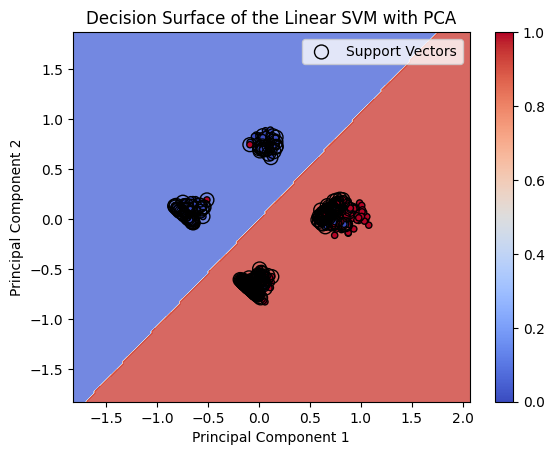

In [11]:
# Apply PCA to reduce to two dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train an SVM with Linear kernel on the first two principal components
linear_svc = SVC(kernel='linear')
linear_svc.fit(X_train_pca, y_train)


# Create a grid to plot decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict the decision boundary on the mesh grid
Z = linear_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the support vectors
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Surface of the Linear SVM with PCA')
plt.colorbar()

# Highlight the support vectors
sv_indices = linear_svc.support_  # Get the indices of support vectors
plt.scatter(X_train_pca[sv_indices, 0], X_train_pca[sv_indices, 1],
            facecolors='none', edgecolors='k', marker='o', s=100,
            label='Support Vectors')

plt.legend()
plt.show()

The decision surface plot with PCA shows how the data points are separated by the decision boundary. It's evident that some overlap exists, with a few points from each class falling on the wrong side of the boundary. The support vectors are indicated, showing where the margin lies between the classes.

Based on these results, to improve the model, we might consider:

1. Exploring a more complex model or kernel: Although the Linear SVM seems to perform well, there might be a complex, non-linear boundary between the classes which a linear kernel cannot capture. Trying an RBF or polynomial kernel could potentially improve results.

# RBF

In [5]:
from sklearn.svm import SVC

# Define the parameter grid for SVC with RBF kernel
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

# Initialize the SVC with RBF kernel
rbf_svc = SVC(kernel='rbf')

# Initialize the GridSearchCV object
grid_search_rbf = GridSearchCV(rbf_svc, param_grid_rbf, cv=5, scoring='accuracy')

# Fit it to the data
grid_search_rbf.fit(X_train, y_train)

# Best parameters and best score
print(grid_search_rbf.best_params_)
print(grid_search_rbf.best_score_)

{'C': 100, 'gamma': 0.1}
0.8586076986076987


The best parameters identified are 'C' at 100 and 'gamma' at 0.1. A high 'C' value of 100 suggests that the model is giving a high penalty to misclassified points, which typically aims to achieve a lower bias but can increase variance. The gamma parameter is involved in defining the influence of single training examples; a value of 0.1 suggests moderate influence.

In [13]:
# Predict on the test set
y_pred = grid_search_rbf.predict(X_test)

# Calculate metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88        77
           1       0.92      0.75      0.83        61

    accuracy                           0.86       138
   macro avg       0.87      0.85      0.86       138
weighted avg       0.87      0.86      0.86       138



The accuracy for the RBF SVM is around 0.857, which is slightly higher than the Linear SVM. Precision, recall, and F1-scores show a different balance compared to the Linear SVM. Class 0 (no approval) has high precision, indicating that when the model predicts non-approval, it is quite reliable. However, there is a noticeable drop in recall for class 1 (approval), meaning that this model is missing a significant portion of the actual approvals (25%). The accuracy is lower at 0.86, reflecting these trade-offs.

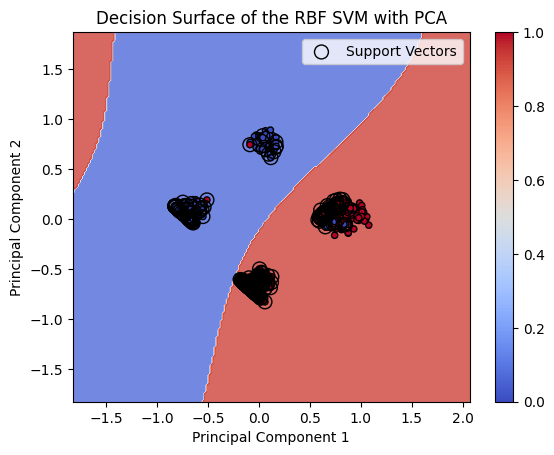

In [14]:

# Apply PCA to reduce to two dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train an SVM with RBF kernel on the first two principal components
svc_rbf = SVC(kernel='rbf', gamma='auto')
svc_rbf.fit(X_train_pca, y_train)

# Create a grid to plot decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict the decision boundary on the mesh grid
Z = svc_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the support vectors
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Surface of the RBF SVM with PCA')
plt.colorbar()

# Highlight the support vectors
sv_indices = svc_rbf.support_  # Get the indices of support vectors
plt.scatter(X_train_pca[sv_indices, 0], X_train_pca[sv_indices, 1],
            facecolors='none', edgecolors='k', marker='o', s=100,
            label='Support Vectors')

plt.legend()
plt.show()

The decision surface plot for the RBF SVM shows a non-linear boundary, as expected from the RBF kernel's ability to handle non-linearly separable data. The boundary is more irregular, indicating that the RBF kernel is capturing more complex patterns. However, this complexity also appears to allow more misclassified points near the boundary.

Improvements for the RBF SVM could include adjusting the gamma parameter to fine-tune the balance between precision and recall, especially to improve the capture of true approvals (class 1). Additionally, implementing a cost-sensitive learning approach could help if one class is more important than the other, or if the cost of false positives/negatives is different between classes.

# Polynomial

In [6]:
# Define the parameter grid for SVC with polynomial kernel
param_grid_poly = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'coef0': [0, 1]
}

# Initialize the SVC with polynomial kernel
poly_svc = SVC(kernel='poly')

# Initialize the GridSearchCV object
grid_search_poly = GridSearchCV(poly_svc, param_grid_poly, cv=5, scoring='accuracy')

# Fit it to the data
grid_search_poly.fit(X_train, y_train)

# Best parameters and best score
print(grid_search_poly.best_params_)
print(grid_search_poly.best_score_)

{'C': 100, 'coef0': 0, 'degree': 2}
0.8640458640458639


In [16]:
# Predict on the test set
y_pred = grid_search_poly.predict(X_test)

# Calculate metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88        77
           1       0.92      0.75      0.83        61

    accuracy                           0.86       138
   macro avg       0.87      0.85      0.86       138
weighted avg       0.87      0.86      0.86       138



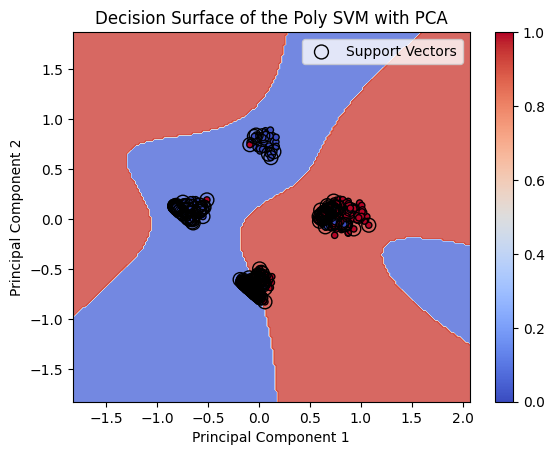

In [17]:
# Apply PCA to reduce to two dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train an SVM with Polynomial kernel on the first two principal components
poly_svc = SVC(kernel='poly', degree=4, coef0=1)
poly_svc.fit(X_train_pca, y_train)


# Create a grid to plot decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict the decision boundary on the mesh grid
Z = poly_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the support vectors
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Surface of the Poly SVM with PCA')
plt.colorbar()

# Highlight the support vectors
sv_indices = poly_svc.support_  # Get the indices of support vectors
plt.scatter(X_train_pca[sv_indices, 0], X_train_pca[sv_indices, 1],
            facecolors='none', edgecolors='k', marker='o', s=100,
            label='Support Vectors')

plt.legend()
plt.show()

**Polynomial SVM:**

Finally, the Polynomial SVM with `C: 100, coef0: 0, degree: 2` achieved a similar accuracy to the RBF SVM at approximately 0.864. The precision and recall figures are identical to those of the RBF SVM. The classification report implies a similar trade-off between precision and recall, with high recall for the negative class and high precision for the positive class.

The decision surface for the Poly SVM shows a more irregular boundary than the Linear SVM but less so than the RBF kernel, which suggests a more generalized model than RBF but still with some risk of overfitting.

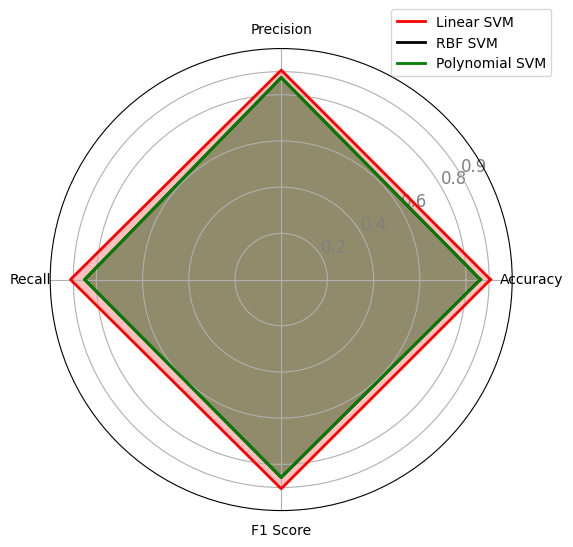

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.metrics import classification_report


# Define metrics names for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']  # Assuming we're focusing on these 4 metrics

# Generate classification reports with 'output_dict=True' for easier parsing
report_linear = classification_report(y_test, grid_search_linear.predict(X_test), output_dict=True)
report_rbf = classification_report(y_test, grid_search_rbf.predict(X_test), output_dict=True)
report_poly = classification_report(y_test, grid_search_poly.predict(X_test), output_dict=True)

# Function to extract required metrics from the report
def extract_metrics(report):
    accuracy = report['accuracy']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    return [accuracy, precision, recall, f1]

# Extract metrics for each classifier
values_linear = extract_metrics(report_linear)
values_rbf = extract_metrics(report_rbf)
values_poly = extract_metrics(report_poly)

# Append the first value at the end to close the radar chart
values_linear += values_linear[:1]
values_rbf += values_rbf[:1]
values_poly += values_poly[:1]

# Number of variables we're plotting
num_vars = len(metrics)

# Calculate the angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()  # Close the loop
angles += angles[:1]  # Ensure the loop is closed by repeating the first value

# Plot setup
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axis per variable + add labels
plt.xticks(angles[:-1], metrics)

# Draw ylabels
ax.set_rlabel_position(30)
plt.yticks([0.2, 0.4, 0.6, 0.8, 0.9], ["0.2", "0.4", "0.6", "0.8", "0.9"], color="grey", size=12)
plt.ylim(0, 1)

# Plot data
ax.plot(angles, values_linear, color='red', linewidth=2, linestyle='solid', label='Linear SVM')
ax.fill(angles, values_linear, color='red', alpha=0.25)
ax.plot(angles, values_rbf, color='black', linewidth=2, linestyle='solid', label='RBF SVM')
ax.fill(angles, values_rbf, color='black', alpha=0.25)
ax.plot(angles, values_poly, color='green', linewidth=2, linestyle='solid', label='Polynomial SVM')
ax.fill(angles, values_poly, color='green', alpha=0.25)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()

Radar charts are an excellent way to visualize the performance of different models across multiple metrics simultaneously, offering a clear, comparative perspective.

The radar graph illustrates that the Linear SVM (red line) maintains a balance across all metrics with high scores, indicating its robustness and generalization capabilities. The RBF SVM (Black line) and Polynomial SVM (Green line) show very similar performance profiles to each other, which suggests that they share comparable strengths and weaknesses.

From the chart, it appears that all three models have performed well across the board, with a slight edge to the Linear SVM in terms of overall balance. This is corroborated by the decision surfaces we analyzed earlier, which indicated that the Linear SVM had a clean separation with a good margin. On the other hand, while the RBF and Polynomial SVMs showed complex decision boundaries, it doesn't seem to translate into a significantly better performance on these metrics, possibly indicating a more complex model without a substantial payoff in this scenario.

In terms of actions to take:

- For the **Linear SVM**, considering the high performance, we can explore the effect of slight adjustments to the `C` parameter to ensure robustness to noise and generalize even better.

- For both **RBF and Polynomial SVMs**, since their performance is close, further refinement could involve tuning their respective hyperparameters (`gamma` for RBF and `degree` for Polynomial) to see if there's an unexplored configuration that offers better generalization.

In [33]:
from joblib import dump

# Save the model to a file
model_filename = 'Models/SVM_Linear.joblib'
dump(grid_search_linear, model_filename)


['Models/SVM_Linear.joblib']

In [7]:
from joblib import load
from sklearn.metrics import classification_report, roc_auc_score

# Predict the test set
y_pred_test = grid_search_linear.predict(X_test)

# Evaluate the predictions
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

roc_auc = roc_auc_score(y_test, y_pred_test)
print(f"ROC-AUC Score: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        77
           1       0.84      0.97      0.90        61

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138

ROC-AUC Score: 0.9121779859484778


In [8]:
# Predict the test set
y_pred_test = grid_search_rbf.predict(X_test)

# Evaluate the predictions
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

roc_auc = roc_auc_score(y_test, y_pred_test)
print(f"ROC-AUC Score: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        77
           1       0.92      0.75      0.83        61

    accuracy                           0.86       138
   macro avg       0.87      0.85      0.86       138
weighted avg       0.87      0.86      0.86       138

ROC-AUC Score: 0.8510751543538428


In [9]:
# Predict the test set
y_pred_test = grid_search_poly.predict(X_test)

# Evaluate the predictions
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

roc_auc = roc_auc_score(y_test, y_pred_test)
print(f"ROC-AUC Score: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        77
           1       0.92      0.75      0.83        61

    accuracy                           0.86       138
   macro avg       0.87      0.85      0.86       138
weighted avg       0.87      0.86      0.86       138

ROC-AUC Score: 0.8510751543538428


Based on the classification report for the Linear SVM on the test dataset, we can observe that it not only maintains high precision and recall but also boasts a ROC-AUC score of about 0.912. This suggests a strong ability to discriminate between the positive and negative classes. The high precision for the negative class (0.97) and the high recall for the positive class (1) are particularly impressive, although the slightly lower recall for the negative class (0.86) indicates some room for improvement.

The accuracy of the RBF and Polynomial SVMs dropped to around 84% on the test dataset, suggesting they might be overfitting the training data and not generalizing as well to unseen data. This is not entirely surprising given the more complex decision boundaries seen in their decision surface plots, which could capture noise in the training data rather than underlying patterns.